In [1]:
print("Setting CUDA devices...")
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="6"

from fastai.conv_learner import *
from fastai.dataset import *

import pandas as pd
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tnrange, tqdm_notebook
from scipy import ndimage

print("Setting variables...")
DATASET_ROOT = '/media/ssd-data/datasets/airbus/'
#DATASET_ROOT = '/media/data/dev/datasets/airbus/'
PATH = DATASET_ROOT
TRAIN = DATASET_ROOT + 'train/'
TEST = DATASET_ROOT + 'test/'
SEGMENTATION = DATASET_ROOT + 'train_ship_segmentations.csv'
PRETRAINED_DETECTION_PATH = DATASET_ROOT + 'fine-tuning-resnet34-on-ship-detection/models/'
PRETRAINED = DATASET_ROOT + 'models/Resnet34_lable_256_1.h5'
PRETRAINED_SEGMENTATION_PATH = DATASET_ROOT + 'unet34-dice-0-87/models/'
DETECTION_TEST_PRED = DATASET_ROOT + 'fine-tuning-resnet34-on-ship-detection/ship_detection.csv'
exclude_list = ['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
                '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg', 
                'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
                'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg'] #corrupted images

Setting CUDA devices...


/home/ben/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Setting variables...


In [2]:
!ls {PATH}/models

Resnet34_lable_256_1.h5  Resnet34_lable_384_1.h5  tmp.h5


In [2]:
nw = 2   #number of workers for data loader
arch = resnet34 #specify target architecture
train_names = [f for f in os.listdir(TRAIN)]
test_names = [f for f in os.listdir(TEST)]
for el in exclude_list:
    if(el in train_names): train_names.remove(el)
    if(el in test_names): test_names.remove(el)
#5% of data in the validation set is sufficient for model evaluation
tr_n, val_n = train_test_split(train_names, test_size=0.05, random_state=42)
segmentation_df = pd.read_csv(os.path.join(PATH, SEGMENTATION)).set_index('ImageId')


def cut_empty(names):
    return [name for name in names 
            if(type(segmentation_df.loc[name]['EncodedPixels']) != float)]

tr_n = cut_empty(tr_n)
val_n = cut_empty(val_n)

def get_mask(img_id, df):
    shape = (768,768)
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    masks = df.loc[img_id]['EncodedPixels']
    if(type(masks) == float): return img.reshape(shape)
    if(type(masks) == str): masks = [masks]
    for mask in masks:
        s = mask.split()
        for i in range(len(s)//2):
            start = int(s[2*i]) - 1
            length = int(s[2*i+1])
            img[start:start+length] = 1
    return img.reshape(shape).T

In [3]:
def get_data(sz,bs):
    #data augmentation
    aug_tfms = [RandomRotate(20, tfm_y=TfmType.CLASS),
                RandomDihedral(tfm_y=TfmType.CLASS),
                RandomLighting(0.05, 0.05, tfm_y=TfmType.CLASS)]
    tfms = tfms_from_model(arch, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, 
                aug_tfms=aug_tfms)
    tr_names = tr_n if (len(tr_n)%bs == 0) else tr_n[:-(len(tr_n)%bs)] #cut incomplete batch
    ds = ImageData.get_ds(pdFilesDataset, (tr_names,TRAIN), 
                (val_n,TRAIN), tfms, test=(test_names,TEST))
    md = ImageData(PATH, ds, bs, num_workers=nw, classes=None)
    #md.is_multi = False
    return md

class pdFilesDataset(FilesDataset):
    def __init__(self, fnames, path, transform):
        self.segmentation_df = pd.read_csv(SEGMENTATION).set_index('ImageId')
        super().__init__(fnames, transform, path)
    
    def get_x(self, i):
        img = open_image(os.path.join(self.path, self.fnames[i]))
        if self.sz == 768: return img 
        else: return cv2.resize(img, (self.sz, self.sz))
    
    def get_y(self, i):
        mask = np.zeros((768,768), dtype=np.uint8) if (self.path == TEST) \
            else get_mask(self.fnames[i], self.segmentation_df)
        img = Image.fromarray(mask).resize((self.sz, self.sz)).convert('RGB')
        return np.array(img).astype(np.float32)
    
    def get_c(self): return 0

In [4]:
cut,lr_cut = model_meta[arch]
def get_base():                   #load ResNet34 model
    layers = cut_model(arch(True), cut)
    return nn.Sequential(*layers)

def load_pretrained(model, path): #load a model pretrained on ship/no-ship classification
    weights = torch.load(PRETRAINED, map_location=lambda storage, loc: storage)
    model.load_state_dict(weights, strict=False)
            
    return model
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))

class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()
    
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()
            
class UnetModel():
    def __init__(self,model,name='Unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

In [5]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0

    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.mean()

In [6]:
class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)
        
    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()
    
def dice(pred, targs):
    pred = (pred>0).float()
    return 2.0 * (pred*targs).sum() / ((pred+targs).sum() + 1.0)

def IoU(pred, targs):
    pred = (pred>0).float()
    intersection = (pred*targs).sum()
    return intersection / ((pred+targs).sum() - intersection + 1.0)


In [8]:


m_base = load_pretrained(get_base(),PRETRAINED)
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [9]:
#models.model

Unet34(
  (rn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pa

In [9]:
sz = 256 #image size
bs = 64  #batch size 64 for 256x256 => 8GB

md = get_data(sz,bs)

In [10]:

learn = ConvLearner(md, models)
# Choose GPU
#learn.models.model = torch.nn.DataParallel(learn.models.model,device_ids=[3, 4, 5, 6])

learn.opt_fn=optim.Adam
learn.crit = MixedLoss(10.0, 2.0)
learn.metrics=[accuracy_thresh(0.5),dice,IoU]
wd=1e-7

In [12]:
learn.freeze_to(1)


In [13]:
learn.fit(1e-2,1,wds=wd,cycle_len=1,use_clr=(5,8))

epoch      trn_loss   val_loss   <lambda>   dice       IoU        
    0      0.341922   0.318741   0.998069   0.791061   0.65499   



[array([0.31874]), 0.9980691467556801, 0.7910613233283977, 0.6549898001638196]

In [14]:
learn.save('Unet34_256_0')

In [15]:
lr = 1e-3
lrs = np.array([lr/100,lr/10,lr])
learn.unfreeze() #unfreeze the encoder
learn.bn_freeze(True)

In [16]:
learn.fit(lr,2,wds=wd,cycle_len=1,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice       IoU        
    0      0.300945   0.280931   0.998277   0.813729   0.686483  
    1      0.278206   0.261109   0.998394   0.824925   0.702489  



[array([0.26111]), 0.9983942167520685, 0.8249249772113261, 0.7024887567692051]

In [17]:
learn.fit(lr/2,2,wds=wd,cycle_len=2,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice       IoU        
    0      0.279328   0.265093   0.998366   0.821892   0.698287  
    1      0.236375   0.238879   0.998506   0.837836   0.72129   
    2      0.255596   0.252334   0.998442   0.830031   0.709877  
    3      0.230348   0.229498   0.99856    0.84335    0.72954   



[array([0.2295]), 0.9985597399041249, 0.8433500472038333, 0.7295402920537655]

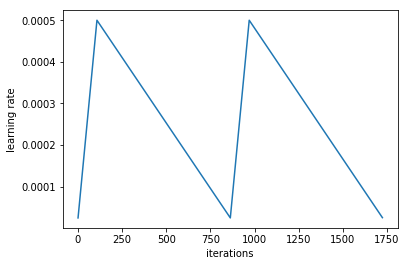

In [18]:
learn.sched.plot_lr()

In [19]:
learn.save('Unet34_256_1')

In [14]:
learn.load('Unet34_256_1')

In [15]:
sz = 384 #image size
bs = 16  #batch size
lr = 1e-3
md = get_data(sz,bs)
learn.set_data(md)
learn.unfreeze()
learn.bn_freeze(True)

In [16]:
learn.fit(lr/8,1,wds=wd,cycle_len=2,use_clr=(10,8))

epoch      trn_loss   val_loss   <lambda>   dice       IoU        
    0      0.225667   0.234178   0.998605   0.841156   0.729913  
    1      0.211131   0.215023   0.998722   0.852875   0.746972  



[array([0.21502]), 0.998721573240979, 0.8528745648182692, 0.7469716677429827]

In [17]:
learn.save('Unet34_384_1')

In [18]:
sz = 768 #image size
bs = 6  #batch size 6 x 768 => 10GB

md = get_data(sz,bs)
learn.set_data(md)
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
learn.fit(lr/20,1,wds=wd,cycle_len=1,use_clr=(10,8))

  9%|▉         | 403/4599 [02:49<29:23,  2.38it/s, loss=0.396]

In [ ]:
learn.save('Unet34_768_1')